In [36]:
# Data manipulation
import numpy as np
import pandas as pd
np.random.seed(2)
pd.options.display.max_columns = None

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

# Modelling 
import lightgbm as lgb
from scipy.stats import expon, randint, uniform
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split

# Bayesian optimization
from bayes_opt import BayesianOptimization

# NLP
from gensim.models import Word2Vec
from nltk import word_tokenize

# Other
import utility as util
import importlib 
importlib.reload(util)
import joblib

# Display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<module 'utility' from 'D:\\MEGA\\Projects\\CSI 4106\\csi4106-repo\\Notebooks\\utility.py'>

## Load preprocessed data

In [2]:
reviews_preprocessed = pd.read_csv('../Datasets/processedAnimeReviews.csv', index_col = 'id')

In [3]:
reviews_preprocessed.head(10)

,workName,overallRating,review,sentiment
id,,,,
8121,Cowboy_Bebop,10,cowboy bebop episodic series episodic mean one...,1
63480,Utawarerumono,8,utawarerumono manages one harem anime anyone p...,1
8452,Hajime_no_Ippo,10,first let say fan boxing fact pretty much hate...,1
66544,Gensoumaden_Saiyuuki,9,saiyuki one anime grab first episode let go ev...,1
55936,Ranma_½,7,comedy romance based manga rumiko takahashi ra...,0
22039,Kino_no_Tabi__The_Beautiful_World,9,say anime traveler journeying different countr...,1
68626,Kareshi_Kanojo_no_Jijou,8,kare kano romance anime could become incredibl...,1
18797,Hunter_x_Hunter,10,overall best anime actually seen anything else...,1
43899,Golden_Boy,10,overall honestly really care others opinion an...,1


## Apply Word2Vec

In [4]:
# load model
w2v_model = Word2Vec.load('../Models/w2vmodel.bin')

In [5]:
# Get mean feature vector of all words in a sentence
def meanFeatureVec(sentence, word_vectors):
    word_vecs = [word_vectors[word] for word in word_tokenize(sentence)]
    mean_vec = np.asarray(word_vecs).mean(axis=0)
    return mean_vec

# Takes a dataframe of the reviews and returns a new dataframe of the word embeddings per review
def reviewToVectors(sentences, word_vectors):
    sent_vecs = [meanFeatureVec(sentence, word_vectors) for sentence in sentences]
    df = pd.DataFrame(sent_vecs, index=sentences.index)
    return df

In [6]:
# # Convert reviews to word embeddings
# X_vectors = reviewToVectors(reviews_preprocessed['review'], w2v_model.wv)

# Load presaved results
X_vectors = pd.read_csv('../Datasets/reviewsWordVectors.csv', index_col='id')

# # Save reviews
# X_vectors.to_csv('../Datasets/reviewsWordVectors.csv')

In [7]:
# Split into train and test
y = reviews_preprocessed[['sentiment', 'overallRating']]

X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.1, random_state=2)

## Dummy model

In [8]:
metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

In [9]:
clf_dummy = DummyClassifier()
scores = util.cross_validate_scores(clf_dummy, X_train, y_train['sentiment'], cv=5, metrics=metrics)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Training scores
accuracy: 0.5106 (0.0016)
recall: 0.5699 (0.0021)
precision: 0.5714 (0.0014)
f1: 0.5703 (0.0009)
roc_auc: 0.5012 (0.0010)

Validation Scores
accuracy: 0.5099 (0.0020)
recall: 0.5689 (0.0038)
precision: 0.5696 (0.0024)
f1: 0.5711 (0.0022)
roc_auc: 0.4997 (0.0031)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Above is the worst baseline/worst accuracy we will be using. The above strategy randomly predicts a class based on the probability distribution of the observed samples.

## LightGBM Model

In [27]:
clf_lgb = lgb.LGBMClassifier(n_jobs=-1)

scores = util.cross_validate_scores(clf_lgb, X_train, y_train['sentiment'], cv=5, metrics=metrics)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Training scores
accuracy: 0.7795 (0.0006)
recall: 0.8434 (0.0012)
precision: 0.7859 (0.0004)
f1: 0.8136 (0.0006)
roc_auc: 0.8626 (0.0004)

Validation Scores
accuracy: 0.7489 (0.0017)
recall: 0.8172 (0.0040)
precision: 0.7605 (0.0004)
f1: 0.7878 (0.0020)
roc_auc: 0.8287 (0.0018)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.2s finished


From the average fold validation scores it seems like the model is doing a pretty good job of not overfitting. As well it does much better than the baseline dummy model. We can perform some grid searching to try and gain lower bias ...

### Randomized search

Randomized search was chosen over the brute force grid search as grid searching would've taken too long and random search provides decent results in a much smaller amount of time

In [10]:
# Start with frehs model
clf_lgb = lgb.LGBMClassifier(n_jobs=-1)

lgb_params_dists = {
    'num_leaves': randint(1, 100),
    'max_depth': [-1, 2, 4, 8, 10, 15],
    'min_child_samples': randint(1, 40),
    'min_child_weight': uniform(1e-4, 1e-1),
    'n_estimators': randint(100, 2000),
    'reg_alpha': uniform(1e-3, 1e1),
    'reg_lambda': uniform(1e-3, 1e1),
}

lgb_random_search = RandomizedSearchCV(
    estimator = clf_lgb, 
    param_distributions = lgb_params_dists, 
    n_iter = 500,
    scoring = metrics,
    refit = 'accuracy',
    cv = 5,
    iid = True,
    n_jobs = -1,
    return_train_score = True,
    verbose = 1)

In [11]:
# Load pre saved grid search
lgb_random_search = joblib.load('../Models/lgb_grid_search.pkl')

# # Fit grid search
# lgb_random_search.fit(X_train, y_train['sentiment'])

# # Save grid search results 
# joblib.dump(lgb_random_search, '../Models/lgb_grid_search.pkl')

In [37]:
# Check best model

lgb_random_search.best_params_
print()
lgb_random_search_scores = util.best_grid_search_results(lgb_random_search)

{'max_depth': 4,
 'min_child_samples': 11,
 'min_child_weight': 0.05472073199021581,
 'n_estimators': 992,
 'num_leaves': 68,
 'reg_alpha': 7.965547700906099,
 'reg_lambda': 50.52560901217039}


Training scores
accuracy: 0.89516036 (0.00052821)
recall: 0.97303050 (0.00027790)
precision: 0.90459717 (0.00039766)
f1: 0.93756672 (0.00030849)
roc_auc: 0.93812933 (0.00045325)

Validation scores
accuracy: 0.85844389 (0.00227024)
recall: 0.95497126 (0.00211849)
precision: 0.88022571 (0.00113323)
f1: 0.91607548 (0.00138939)
roc_auc: 0.86893571 (0.00228602)


The best parameters found are shown above. Seems fairly reasonable though, max depth of 4 is not too deep and min child samples per leaf is 11 which is also enough which both help to prevent overfitting. There are 992 estimators which is much greater than the 100 default ones and so with more trees this helps to decrease the variance of the estimates. The regularization parameters do seem quite high though of alpha=8 and lambda=50 but this is most likely because the random search found that it needed these to account reduce overfitting and decrease variance of the estimators.

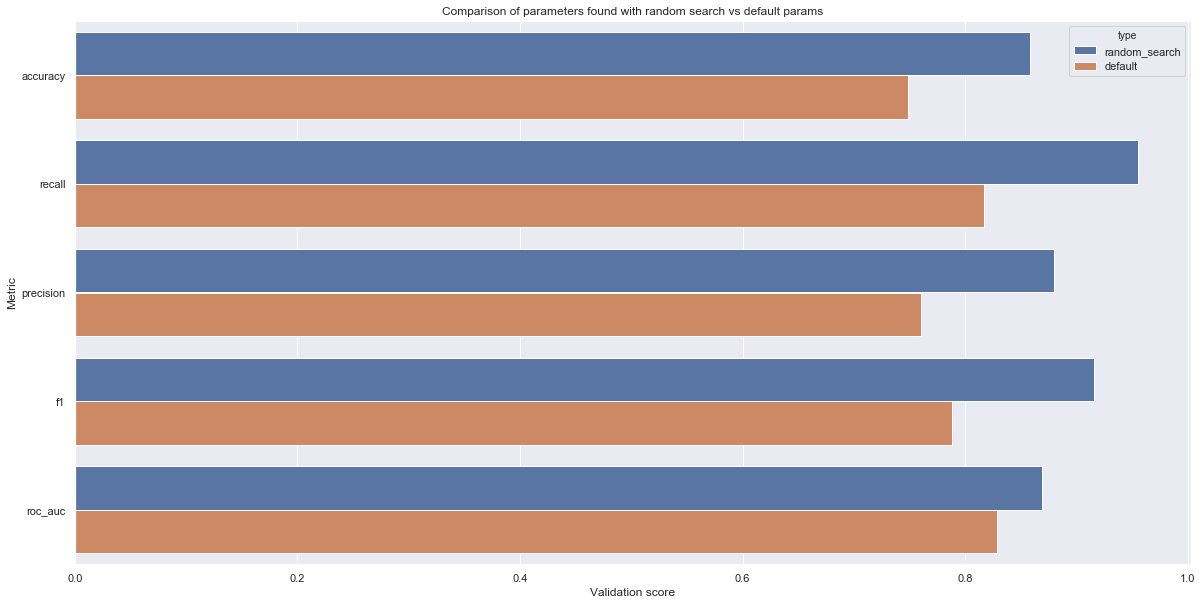

In [59]:
# Compare default params with our new params from the random search

scores['type'] = 'default'
lgb_random_search_scores['type'] = 'random_search'

combined_scores = lgb_random_search_scores.append(scores, ignore_index=True)

f = plt.figure(figsize=(20,10))
g = sns.barplot(x = 'val_scores',
                y = 'metric', 
                data = combined_scores,
                hue = 'type')
g = g.set(ylabel='Metric', xlabel='Validation score', title='Comparison of parameters found with random search vs default params')

Overall, the parameters found with the random search do much better than our default ones that we started with in all metrics and by a significant amount as well. By randomly sampling the parameter space we were able to automate the process of fine tuning the parameters, which would've been much more difficult and time consuming to do it manually.

### Bayesian Optimization

The next approach is bayesian optimization, a more sophisticated method of finding the best parameters by modelling the functions as gaussian processes. For this we will be using the ROC AUC as the metric to optimize and we will be attempting to maximize with respect to the same parameters of the LGB that we defined above for our random search

In [62]:
def lgb_score(num_leaves, max_depth, min_child_samples, min_child_weight, n_estimators, reg_alpha, reg_lambda):
    '''
    Define scoring function for bayesian optimizer 
    NOTE: we will be rounding the real numbers to nearest integers for discrete parameters. Small workaround as the package does not explicitly handle discrete parameters
    '''
    num_leaves = int(round(num_leaves))
    max_depth = int(round(max_depth))
    min_child_samples = int(round(min_child_samples))
    n_estimators = int(round(n_estimators))
    
    clf_lgb = lgb.LGBMClassifier(num_leaves = num_leaves,
                                 max_depth = max_depth,
                                 min_child_samples = min_child_samples,
                                 min_child_weight = min_child_weight,
                                 n_estimators = n_estimators, 
                                 reg_alpha = reg_alpha,
                                 reg_lambda = reg_lambda)
    
    score = cross_val_score(clf_lgb, X_train, y_train['sentiment'], scoring='roc_auc', cv=5, n_jobs=-1).mean()
    
    return score


# Bounds for parameter space
pbounds = {
    'num_leaves': (1, 100),
    'max_depth': (1, 50),
    'min_child_samples': (1, 40),
    'min_child_weight': (1e-4, 1e-1),
    'n_estimators': (100, 2000),
    'reg_alpha': (1e-3, 1e1),
    'reg_lambda': (1e-3, 1e1)
}

In [61]:
%%time

# Run bayesian optimization
optimizer = BayesianOptimization(
    f = lgb_score,
    pbounds = pbounds,
    random_state = 2
)

optimizer.maximize(
    init_points = 5,
    n_iter = 100
)

|   iter    |  target   | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.8382   |  22.93    |  2.011    |  0.05501  |  927.1    |  42.62    |  3.304    |  2.047    |
|  2        |  0.838    |  31.73    |  12.69    |  0.02676  |  1.28e+03 |  53.39    |  1.347    |  5.136    |
|  3        |  0.8381   |  10.85    |  31.63    |  0.08541  |  1.039e+0 |  84.81    |  0.7974   |  5.053    |
|  4        |  0.8364   |  5.134    |  17.7     |  0.009743 |  341.6    |  60.08    |  2.261    |  1.07     |
|  5        |  0.8392   |  12.57    |  14.64    |  0.04683  |  483.3    |  64.4     |  4.831    |  5.053    |


LightGBMError: Check failed: num_leaves >1 at C:\Users\VssAdministrator\AppData\Local\Temp\pip-req-build-epx2wdd_\compile\src\io\config_auto.cpp, line 304 .


## Test set scores